In [537]:
import warnings

from functools import lru_cache
from itertools import product

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import uniform, randint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm

# Accounts

In [2]:
# Load account data
accounts_df = pd.read_csv('data/accounts.csv', parse_dates=['update_date'])

In [3]:
# Inspect schema
accounts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           1254 non-null   int64         
 1   balance      1254 non-null   float64       
 2   update_date  1254 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 29.5 KB


,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
balance,1254.0,2495.186994,11853.402866,-98240.37,-7497.072,-148.342,0.58,2.975,15.244,72.065,247.908,690.044,1753.47,5670.866,52343.4789,216975.66


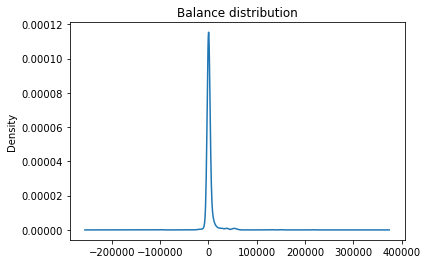

In [4]:
# General distribution of `balance` per account and quantiles
accounts_df.balance.plot.kde(title='Balance distribution')
accounts_df[['balance']].describe(percentiles=list(np.arange(0.1,1,0.1))+[0.01,0.99]).transpose()

<AxesSubplot:title={'center':'Distribution of the 98% quantile of Balance'}, ylabel='Density'>

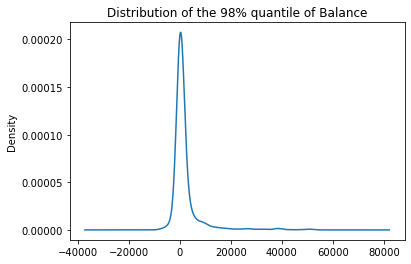

In [5]:
# Distribution of 98 % of the probability mass
accounts_df.balance.loc[
    (accounts_df.balance>accounts_df.balance.quantile(0.01))&(
        accounts_df.balance<accounts_df.balance.quantile(0.99))
    ].plot.kde(title='Distribution of the 98% quantile of Balance')

In [6]:
# Distribution of `update_date`.
accounts_df.update_date.describe(datetime_is_numeric=True)

count                   1254
mean     2021-07-02 00:00:00
min      2021-07-02 00:00:00
25%      2021-07-02 00:00:00
50%      2021-07-02 00:00:00
75%      2021-07-02 00:00:00
max      2021-07-02 00:00:00
Name: update_date, dtype: object

# Transactions

In [7]:
# Load transactions
transactions_df = pd.read_csv('data/transactions.csv', parse_dates=['date'])

In [8]:
# Inspect schema
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518229 entries, 0 to 518228
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   account_id  518229 non-null  int64         
 1   date        518229 non-null  datetime64[ns]
 2   amount      518229 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.9 MB


In [9]:
# Helper function to slice the transaction time series by account_id
transactions_by_account_and_date = transactions_df.set_index(['account_id','date'])
def get_single_transaction_time_series(account_id:int)->pd.DataFrame:
    return transactions_by_account_and_date.loc[(account_id, slice(None))]

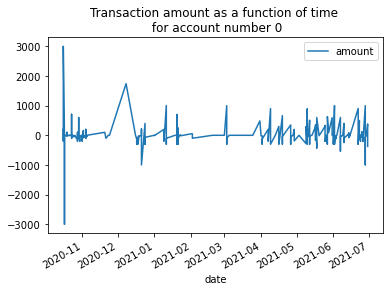

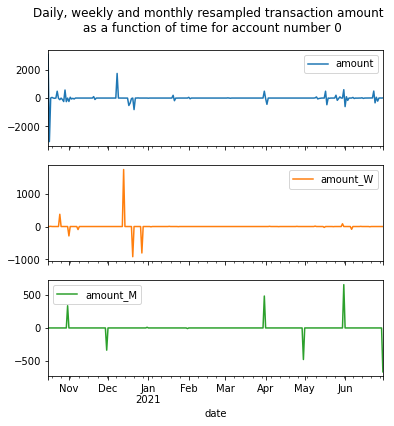

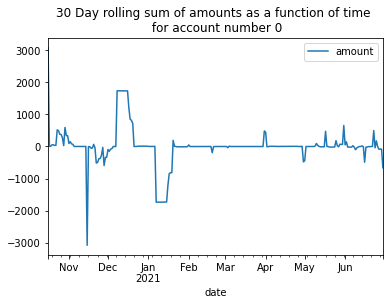

In [10]:
# Plotting a single account_id time series resampling by day, week and month
account_number = 0
single_series_data = get_single_transaction_time_series(account_number)
single_series_data.plot(title=f'Transaction amount as a function of time \n for account number {account_number}')
single_series_data_resampled = single_series_data.resample('d').sum()
for frequency in ['W', 'M']:
    single_series_data_resampled[f'amount_{frequency}'] = single_series_data_resampled['amount'].resample(frequency).sum()
single_series_data_resampled.fillna(0).plot(subplots=True, figsize=(6, 6), 
title=f'Daily, weekly and monthly resampled transaction amount \n as a function of time for account number {account_number}')
single_series_data.resample('d').sum().rolling('30d').sum().plot(
    title=f'30 Day rolling sum of amounts as a function of time \n for account number {account_number}')
plt.show()

# Hypothesis

## Linear Models

In [11]:
# Observation 1: The outgoing tends to match and cancel the income 
# "You tend to expend what you have"
# "Tell me how much you have and I'll tell you how much you will expend."
# Idea 1: Measure the correlation between incoming with the outgoing.

In [12]:
class TransactionTimeSeries:
    '''Encapsulates a single transaction time series'''
    def __init__(self, account_id, transactions, balance):
        self.account_id = account_id
        self.transactions = transactions
        self.balance = balance
        self.transaction_date_start = self.transactions.index.get_level_values('date').min()
        self.transaction_date_last = self.transactions.index.get_level_values('date').max()
        self.transaction_date_span = self.transaction_date_last - self.transaction_date_start
    
    def incoming_transactions(self):
        '''Returns the transactions with a positive amount'''
        return TransactionTimeSeries(self.account_id, self.transactions[self.transactions>0].dropna(), self.balance)

    def outgoing_transactions(self):
        '''Returns the transactions with a negative amount'''
        return TransactionTimeSeries(self.account_id, self.transactions[self.transactions<0].dropna(), self.balance)

    @lru_cache
    def transactions_after_n_days(self, number_of_days:int):
        '''Returns the transactions spanning from the start date up until the start date plus the given number of days'''
        return TransactionTimeSeries(
            self.account_id,
            self.transactions.loc[(slice(None), pd.date_range(
                start=self.transaction_date_start, 
                periods=number_of_days)), :], 
            self.balance)

    @lru_cache
    def remaining_transactions_after_n_days(self, number_of_days:int):
        '''Returns the transactions spanning from the start date plus the given number of days up until the last date'''
        return TransactionTimeSeries(
            self.account_id,
            self.transactions.loc[(slice(None), pd.date_range(
                start=self.transaction_date_start+pd.DateOffset(number_of_days), 
                end=self.transaction_date_last)), :], 
            self.balance)

    @lru_cache
    def transactions_from_n_to_m_days(self, n_number_of_days:int, m_number_of_days:int):
        '''Returns the transactions spanning from the start date + n days up until the start date + m days'''
        return TransactionTimeSeries(
            self.account_id,
            self.transactions.loc[(slice(None), pd.date_range(
                start=self.transaction_date_start+pd.DateOffset(n_number_of_days), 
                end=self.transaction_date_start+pd.DateOffset(m_number_of_days))), :], 
            self.balance)

    def resample(self, frequency: str)->pd.DataFrame:
        '''Returns a timeseries resampled by a given frequency'''
        return self.transactions.droplevel(level=0).resample(frequency)

    def __call__(self)->pd.DataFrame:
        return self.transactions


class TransactionsTimeSeries:
    '''Encapsulates the transactions and accounts files to be exploited as time series'''
    def __init__(self, transactions_df, accounts_df):
        self._transactions_df = transactions_df.copy().reset_index().set_index(['index','account_id','date'])
        self._accounts_df = accounts_df.copy().set_index('id')
        self.transactions = {
            account_id: transaction_time_series for account_id, transaction_time_series in
            {
                account_id: TransactionTimeSeries(
                    account_id,
                    self._transactions_df.loc[(slice(None), account_id, slice(None)), :].droplevel(level='account_id'),
                    self._accounts_df.loc[account_id, :]
                ) for account_id in self._accounts_df.index
            }.items()
            if transaction_time_series.transaction_date_span.days > 180 
            # Filter accounts with less than 180 days of transactions
        }
        self.accounts = tuple(self.transactions.keys())

    def __call__(self, account_id:int)->TransactionTimeSeries: 
        return self.transactions[account_id]


In [13]:
def construct_training_set(dataset, target_label='outgoing_to_predict'):
    '''Make a training and testing set'''
    training_sets = dict()
    (
        training_sets['X_train'], 
        training_sets['X_test'],
        training_sets['y_train'],
        training_sets['y_test']
        ) = train_test_split(
            dataset.drop(target_label, axis=1).to_numpy(), 
            dataset[target_label].to_numpy(), 
            test_size=0.2, random_state=0)
    return training_sets

def cross_validate_estimator(estimator, dataset, cv_number = 10):
    '''Estimate the R^2 of the model and using cross validation'''
    return cross_val_score(
        estimator, 
        dataset['X_train'],
        dataset['y_train'], 
        cv=cv_number,
        )

def model_residuals(estimator, testing_set):
    '''Compute the residuals of the predicted value with of out-of-sample data.'''
    return pd.DataFrame.from_dict({
        'predicted_value': estimator.predict(testing_set['X_test']), 
        'residual' : testing_set['y_test'] - estimator.predict(testing_set['X_test'])
    }
        )

In [14]:
TTS = TransactionsTimeSeries(
    transactions_df=pd.read_csv('data/transactions.csv', parse_dates=['date']), 
    accounts_df=pd.read_csv('data/accounts.csv', parse_dates=['update_date'])
)

In [15]:
# Computes the absolute aggregated income and outcome from the provided transactions
income_outcome_pairs = pd.DataFrame(
    [
        (
            abs(TTS(account_id).incoming_transactions()().sum().amount),
            TTS(account_id).balance.balance,
            abs(TTS(account_id).outgoing_transactions()().sum().amount)
        )
        for account_id in list(TTS.accounts)
    ], 
    columns = ['income', 'balance', 'outcome']
)

<AxesSubplot:xlabel='income', ylabel='outcome'>

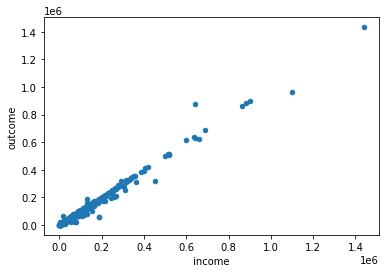

In [16]:
income_outcome_pairs.plot(kind='scatter', x='income', y='outcome')
# The relation of income and outcome seems pretty linear, let us measure how much.

In [17]:
ols_model = linear_model.LinearRegression()
ols_model.fit(income_outcome_pairs.income.to_numpy().reshape(-1, 1), income_outcome_pairs.outcome.to_numpy())
f'The income is a predictor for outcome with a linear coeficient of around {ols_model.coef_} within the in-sample data and and an intercept of {ols_model.intercept_:.2f}'

'The income is a predictor for outcome with a linear coeficient of around [0.98272277] within the in-sample data and and an intercept of -836.58'

In [18]:
income_outcome_pairs_training_sets = construct_training_set(income_outcome_pairs.drop('balance', axis=1), 'outcome')

In [19]:
ols_model.fit(
    income_outcome_pairs_training_sets['X_train'], 
    income_outcome_pairs_training_sets['y_train']
)
ols_model_test_score = ols_model.score(
    income_outcome_pairs_training_sets['X_test'],
    income_outcome_pairs_training_sets['y_test']
)
f'The income is a predictor for outcome with a determination coeficient of around {ols_model_test_score:.3f} within the out-sample data'

'The income is a predictor for outcome with a determination coeficient of around 0.992 within the out-sample data'

In [20]:
cv_scores = cross_validate_estimator(linear_model.LinearRegression(), income_outcome_pairs_training_sets)
f"Estimated an R^2 of {cv_scores.mean():.3f} with a standard deviation of {cv_scores.std():.3f}"

'Estimated an R^2 of 0.981 with a standard deviation of 0.012'

'The variance of the residuals is 131656209.926'

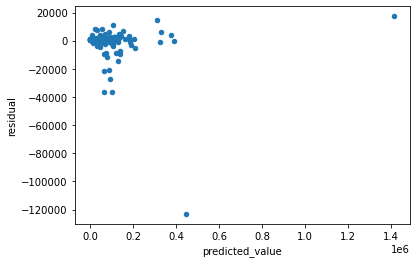

In [21]:
linear_residuals = model_residuals(ols_model, income_outcome_pairs_training_sets)
linear_residuals.plot(kind='scatter', x='predicted_value', y='residual')
# Some residuals are outliers.
f'The variance of the residuals is {linear_residuals.residual.var():.3f}'

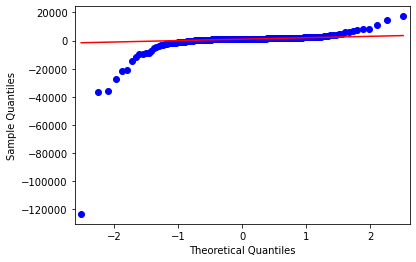

In [22]:
sm.qqplot(linear_residuals.residual, line='q')
plt.show()

In [23]:
# I think i can try to add the `balance` as a feature and see if it reduces the outliers

In [24]:
# Estimate a model with the balance as additional feature using cross validation
income_outcome_pairs_training_sets = construct_training_set(income_outcome_pairs, 'outcome')
        
cv_scores = cv_scores = cross_validate_estimator(linear_model.LinearRegression(), income_outcome_pairs_training_sets)
f"Estimated an R^2 of {cv_scores.mean():.3f} with a standard deviation of {cv_scores.std():.3f}"

'Estimated an R^2 of 0.987 with a standard deviation of 0.012'

The variance of the residuals is 17636690.222
Variance was reduced on 86.604%


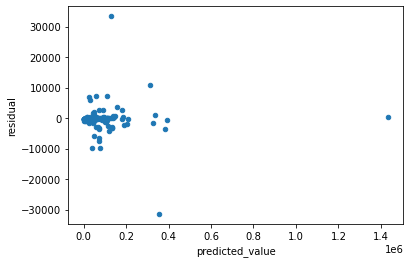

In [25]:
ols_model_2 = linear_model.LinearRegression()
ols_model_2.fit(income_outcome_pairs_training_sets['X_train'], income_outcome_pairs_training_sets['y_train'])

linear_residuals_2 = model_residuals(ols_model_2, income_outcome_pairs_training_sets)
linear_residuals_2.plot(kind='scatter', x='predicted_value', y='residual')
print(f'The variance of the residuals is {linear_residuals_2.residual.var():.3f}')
print(f'Variance was reduced on {100*(linear_residuals.residual.var()-linear_residuals_2.residual.var())/linear_residuals.residual.var():.3f}%')

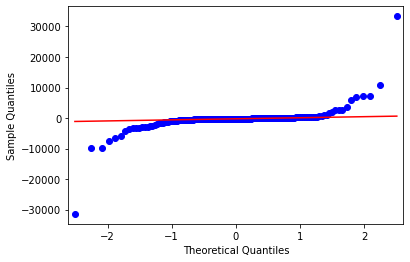

In [26]:
sm.qqplot(linear_residuals_2.residual, line='q')
plt.show()

In [27]:
f'The income and balance are predictors for outgoing with a linear coeficient of around {ols_model_2.coef_} within the in-sample data and and an intercept of {ols_model_2.intercept_:.2f}'

'The income and balance are predictors for outgoing with a linear coeficient of around [ 0.99601155 -0.74640318] within the in-sample data and and an intercept of 296.14'

In [28]:
# Conclusion : The aggregated incoming and the current balance are strong linear predictors for the aggregated outgoing.

## Prediction using linear model

In [29]:
# In which measure can we predict the coming month based on previous transactions using this kind of linear model ? 
# And which features we may add to improve this prediction ? 

In [30]:
# Let us learn a model using `n` days and testing on the coming 30 days
@lru_cache
def compute_incoming_outgoing_training_dataset(number_of_days):
    periods = [f'{day}d' for day in (1,5,7,10,14,30,45,50,60)]
    return pd.DataFrame(
        [
            (
                TTS(account_id).transactions_after_n_days(number_of_days).incoming_transactions()().sum().amount, 
                # The sum of incoming transactions
                TTS(account_id).transactions_after_n_days(number_of_days).outgoing_transactions()().sum().amount, 
                # The sum of outgoing transactions
                TTS(account_id).transactions_after_n_days(number_of_days)().sum().amount, 
                # This should be a proxy of the balance, 
                # that is the sum of outgoing and incoming transactions up to the cut date `n`
                TTS(account_id).transactions_after_n_days(number_of_days)().cumsum().mean().amount,
                # The mean balance 
                *[TTS(account_id).transactions_after_n_days(number_of_days).incoming_transactions(
                    ).resample('d').sum().rolling(period).sum().dropna().mean().amount 
                    for period in periods],
                # The rolling mean of incoming transactions at various periods
                *[TTS(account_id).transactions_after_n_days(number_of_days).outgoing_transactions(
                    ).resample('d').sum().rolling(period).sum().dropna().mean().amount 
                    for period in periods],
                # The rolling mean of outgoing transactions at various periods
                *tuple(TTS(account_id).transactions_after_n_days(number_of_days).incoming_transactions(
                    ).resample('30d').sum().dropna().amount.to_numpy()),
                # The sum of incoming transactions on snapshots of 30 days
                *tuple(TTS(account_id).transactions_after_n_days(number_of_days).outgoing_transactions(
                    ).resample('30d').sum().dropna().amount.to_numpy()),
                # The sum of outgoing transactions on snapshots of 30 days. 
                TTS(account_id).transactions_from_n_to_m_days(
                    number_of_days,number_of_days+30).outgoing_transactions()().sum().amount
                # The sum of outgoing transactions on the 30 days after the cut date `n`, that is the label to predict
            )
            for account_id in tqdm(TTS.accounts)
        ], 
        columns = [
            'incoming_sum', 
            'outgoing_sum',
            'estimated_balance',
            'mean_balance',
            *[f'income_{period}_rolling_mean' for period in periods],
            *[f'outcome_{period}_rolling_mean' for period in periods],
            *[f'monthly_incoming_{i}' for i in range(number_of_days//30)],
            *[f'monthly_outgoing_{i}' for i in range(number_of_days//30)],
            'outgoing_to_predict'
            ]
    ).dropna()

In [31]:
# Create the dataset for `n=180-30=150`
incoming_outgoing_after_n_days = compute_incoming_outgoing_training_dataset(150)

100%|██████████| 823/823 [05:23<00:00,  2.55it/s]


In [32]:
# Split on train and test dataset
income_outcome_pairs_training_sets = construct_training_set(incoming_outgoing_after_n_days, 'outgoing_to_predict')

In [33]:
# Estimate R^2 of a Ridge regression model (for regularization) and it's standard deviation
cv_scores = cross_validate_estimator(linear_model.Ridge(), income_outcome_pairs_training_sets)

f"Estimated an R^2 of {cv_scores.mean():.3f} with a standard deviation of {cv_scores.std():.3f}"

'Estimated an R^2 of 0.393 with a standard deviation of 0.209'

The variance of the residuals is 78044605.127


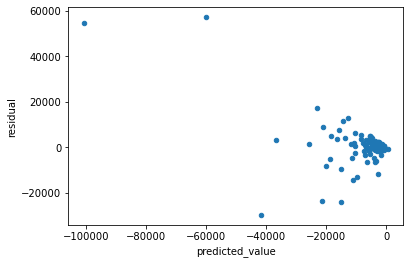

In [34]:
# Estimate the residuals
ols_model_3 = linear_model.Ridge()
ols_model_3.fit(
    income_outcome_pairs_training_sets['X_train'], 
    income_outcome_pairs_training_sets['y_train'])
linear_residuals_3 = model_residuals(ols_model_3, income_outcome_pairs_training_sets)
linear_residuals_3.plot(kind='scatter', x='predicted_value', y='residual')
print(f'The variance of the residuals is {linear_residuals_3.residual.var():.3f}')

In [35]:
# Estimate the feature importance using the testing set
r = permutation_importance(
    ols_model_3, 
    income_outcome_pairs_training_sets['X_test'], 
    income_outcome_pairs_training_sets['y_test'],
    n_repeats=50,
    random_state=0)

<AxesSubplot:>

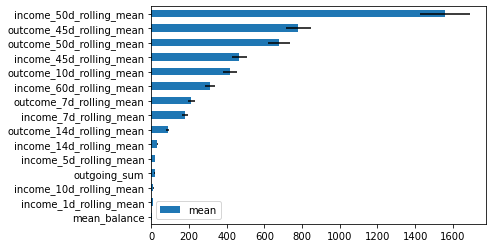

In [36]:
feature_importance = pd.DataFrame(
    [
        r.importances_mean,
        r.importances_std
        ], columns= incoming_outgoing_after_n_days.columns[0:-1], 
        index=['mean','std']).transpose().sort_values('mean', ascending=False
        )
feature_importance.head(15)[::-1].plot.barh(y='mean', xerr='std')
# The most important features are rolling means of the income and outcome signals with different periods. 

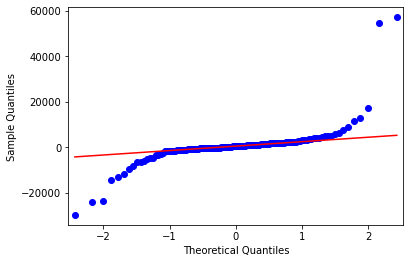

In [37]:
sm.qqplot(linear_residuals_3.residual, line='q')
plt.show()

In [38]:
f'Conclusion: We may estimate the upcoming month based on previous observations with an R^2 of up to {cv_scores.mean():.3f} . \
But the choice of features is somewhat arbitrary and the residuals are not normally distributed'

'Conclusion: We may estimate the upcoming month based on previous observations with an R^2 of up to 0.393 . But the choice of features is somewhat arbitrary and the residuals are not normally distributed'

## Non linear models

In [39]:
# Using the same features, how well can a non linear estimator perform ?

In [40]:
estimators = {
    'LinearRegression' : linear_model.LinearRegression(),
    'Ridge' : linear_model.Ridge(),
    'KNeighborsRegressor' : KNeighborsRegressor(n_neighbors=5), 
    'GradientBoostingRegressor' : GradientBoostingRegressor(), 
    'RandomForestRegressor': RandomForestRegressor(), 
    'MLPRegressor' : MLPRegressor(hidden_layer_sizes=(100,100,100), max_iter=500)
}
cv_scores = {}
residuals = {}
for estimator_name, estimator in tqdm(estimators.items()):
    cv_scores[estimator_name] = cross_validate_estimator(estimator, income_outcome_pairs_training_sets, cv_number=5)
    estimator.fit(income_outcome_pairs_training_sets['X_train'], income_outcome_pairs_training_sets['y_train'])
    residuals[estimator_name] = model_residuals(estimator, income_outcome_pairs_training_sets)

100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


<AxesSubplot:title={'center':'R^2 score of predicted values and the \n held off cross-validation testing set for various models'}>

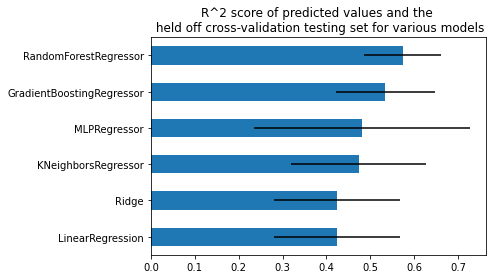

In [41]:
cv_scores_df = pd.DataFrame.from_dict(cv_scores, orient='columns')
mean_model_cv_scores = cv_scores_df.agg(['mean','std']).transpose().sort_values('mean', ascending=False)
mean_model_cv_scores[::-1].plot.barh(y = "mean", xerr = "std", 
title='R^2 score of predicted values and the \n held off cross-validation testing set for various models', 
legend=None)
# Ensemble models such as GBR or RFR can outperform the linear models since they perform feature selection automatically. 
# A linear model trained with the top5 important features can perform similarly. 

In [46]:
print(f'RFR model achieve as much as {mean_model_cv_scores.iloc[0,0]:.3f} R^2 score on cross-validation')
mean_model_cv_scores

RFR model achieve as much as 0.574 R^2 score on cross-validation


,mean,std
RandomForestRegressor,0.573995,0.087381
GradientBoostingRegressor,0.534684,0.112826
MLPRegressor,0.480565,0.246332
KNeighborsRegressor,0.473837,0.153724
Ridge,0.424033,0.143198
LinearRegression,0.423534,0.143272


<AxesSubplot:title={'center':'Mean Average Error on the testing set for various models'}>

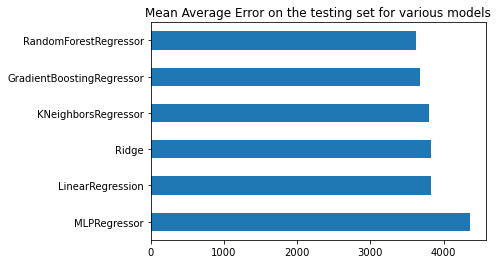

In [43]:
pd.DataFrame.from_dict({
    estimator_name: residuals[estimator_name].residual.apply(abs).mean()
    for estimator_name in residuals.keys()
    }, orient='index', columns=['mae']).sort_values('mae', ascending=False).plot.barh(
        title='Mean Average Error on the testing set for various models',
        legend=None)
# In terms of Mean Average Error, the ensemble models perform best next to the linear regression models.

In [52]:
# Can I further gain R^2 score by doing hyperparameter exploration ?
estimator = RandomForestRegressor()
parameter_space = {
    'n_estimators': randint(1,1000), 
    'max_depth': randint(1,100),
    'min_samples_split': uniform(0.01,0.99),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}
# Doing a Randomized Search of parameters with cross-validation
rscv = RandomizedSearchCV(estimator, parameter_space, random_state=0, n_jobs=-1, return_train_score=True, verbose=1, n_iter=500)
search = rscv.fit(income_outcome_pairs_training_sets['X_train'], income_outcome_pairs_training_sets['y_train'])

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [111]:
cv_std_test_score = search.cv_results_['std_test_score'][search.best_index_]
print(
    search.best_params_, 
    f'\nBest Score : {search.best_score_:.6f}+/-{cv_std_test_score:.6f}'
    )
f'I can find an epsilon-similar estimator with up to {search.best_score_:.3f} R^2 score'

{'bootstrap': True, 'max_depth': 83, 'max_features': 'auto', 'min_samples_split': 0.043433851509655966, 'n_estimators': 868} 
Best Score : 0.573147+/-0.089633


'I can find an epsilon-similar estimator with up to 0.573 R^2 score'

## Time Series

In [ ]:
# Observation 2: Feature importance suggests the importance of rolling means of the signal in previous time steps to predict 
# the upcoming ones. This can be an autoregressive model.
# How good can we predict using time series models ?
# Idea 2 : Use ARIMA model

In [79]:
# Are observations stationary ? 
def try_adfuller(timeseries):
    try:
        return adfuller(timeseries)[0:2]
    except ValueError:
        print('ValueError during adfuller computation, passing')

In [80]:
# Use ADFuller to test for stationarity
stationary_pvalues = pd.DataFrame(
    [
        try_adfuller(TTS(account_id).resample('d').sum())[0:2] for account_id in TTS.accounts
    ],
    columns = ['adf', 'pvalue']
)
stationary_pvalues[['pvalue']].describe(percentiles=list(np.arange(0.1,1,0.1))+[0.95,0.99]).transpose()
# Up to 99% of the timeseries are stationary

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
pvalue,823.0,0.002682,0.042921,0.0,0.0,7.281726e-30,2.620172e-26,3.472017e-22,1.500338e-19,5.370772e-17,1.438233e-14,1.850630e-12,1.663908e-09,2.463629e-07,0.000591,0.928566


In [78]:
# Is it the same for the outgoing transactions only ? 
stationary_pvalues = pd.DataFrame(
    [
        try_adfuller(TTS(account_id).outgoing_transactions().resample('d').sum()) for account_id in TTS.accounts
    ],
    columns = ['adf', 'pvalue']
)
stationary_pvalues[['pvalue']].describe(percentiles=list(np.arange(0.1,1,0.1))+[0.95,0.99]).transpose()
# Up to 95% of the outgoing transactions timeseries are stationary

ValueError during adfuller computation, passing
ValueError during adfuller computation, passing
ValueError during adfuller computation, passing


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
pvalue,820.0,0.022966,0.114065,0.0,0.0,0.0,3.035082e-30,3.793198e-28,3.627373e-25,1.802880e-17,9.177549e-09,0.000066,0.007815,0.093985,0.729584,0.991107


In [309]:
# Create a held out validation and a testing set dataset of outgoing transactions
timeseries_training_dataset = {
    account_id: {
        'train' : TTS(account_id).transactions_after_n_days(120).outgoing_transactions().resample('d').sum(),
        'validation' : TTS(account_id).transactions_from_n_to_m_days(120, 150).outgoing_transactions().resample('d').sum(),
        'test': TTS(account_id).transactions_from_n_to_m_days(150, 180).outgoing_transactions().resample('d').sum()
    } for account_id in tqdm(TTS.accounts)
}

100%|██████████| 823/823 [01:04<00:00, 12.81it/s]


In [577]:
# Test different ARIMA orders and compute quality measures
def compute_quality_measures(model, prediction_comparison):
    '''
    Computes : 
    aic - Akaike information criterion of the model
    mse - The means squared error of the forecast (out of sample) and the timeseries
    mae - The man absolute error of the forecast (out of sample) and the timeseries
    mape - The mean absolute percentage error of the forecast (out of sample) and the timeseries
    ape - The absolute percentage error of the aggregates of the forecast (out of sample) and the timeseries
    residue - The difference between the aggregates of the signal and the forecast
    target_value - The signal aggregate
    predicted_value - The forecast aggregate
    '''
    return {
        'aic': model.aic, 
        'mse': mean_squared_error(prediction_comparison.iloc[:,0], prediction_comparison.iloc[:,1]),
        'mae': mean_absolute_error(prediction_comparison.iloc[:,0], prediction_comparison.iloc[:,1]), 
        'mape': mean_absolute_percentage_error(prediction_comparison.iloc[:,0], prediction_comparison.iloc[:,1]),
        'ape' : abs(abs(prediction_comparison.iloc[:,0].sum()) - 
        abs(prediction_comparison.iloc[:,1].sum()))/abs(prediction_comparison.iloc[:,0].sum()),
        'residue': prediction_comparison.iloc[:,0].sum() - prediction_comparison.iloc[:,1].sum(),
        'target_value': prediction_comparison.iloc[:,0].sum(),
        'predicted_value': prediction_comparison.iloc[:,1].sum(),
        }

def optimize_arima_order(timeseries_train, timeseries_validation, order_space):
    '''
    Compute quality measures of a ARIMA models on orders belonging to the order_space 
    using a timeseries for training and a timeseries for validation.
    '''
    optimization_results = {}
    for order in order_space:
        try:
            model = ARIMA(timeseries_train, order=order).fit()
            prediction_comparison = pd.concat([timeseries_validation, model.forecast(30)], axis=1).fillna(0)
            optimization_results[order] = compute_quality_measures(model, prediction_comparison)
        except np.linalg.LinAlgError:
            continue
        except (IndexError, ValueError):
            continue
    return optimization_results

def optimize_arima_order_of_dataset(timeseries_training_dataset, order_space, criterium='aic'):
    ''' 
    Given a collection of timeseries, it computes the quality measures of a given order_space 
    then it choses the one that minimizes a given criterium member of 
    ['aic', 'mse', 'mae', 'mape', 'ape', 'residue', 'target_value', 'predicted_value']
    then it trains an arima model with the optimized_order for each timeseries and computes 
    quality measures on a test set (out of sample)
    '''
    optimization_results_dataset = {}
    for account_id, timeseries in tqdm(timeseries_training_dataset.items(), desc='training_examples', position=0):
        optimization_results = optimize_arima_order(timeseries['train'], timeseries['validation'], order_space)
        if len(optimization_results) > 0:
            optimization_results_df = pd.DataFrame.from_dict(optimization_results, orient='index').sort_values(criterium)
            for optimized_order in list(optimization_results_df.index):
                try:
                    timeseries_train_validation = pd.concat([
                        timeseries['train'],
                        timeseries['validation']]).resample('d').sum()
                    model = ARIMA(
                        timeseries_train_validation,
                        order=optimized_order
                        ).fit()
                    prediction_comparison = pd.concat([timeseries['test'], model.forecast(30)], axis=1).fillna(0)
                    optimization_results_dataset[account_id] = {
                        'optimized_order': optimized_order,
                        **compute_quality_measures(model, prediction_comparison)
                    }
                    break
                except np.linalg.LinAlgError:
                    continue
                except ValueError:
                    continue
    return optimization_results_dataset


In [578]:
# A order space for (p, d, q)
order_space = list(product(range(0,4), range(0,2), range(0,4)))

In [581]:
warnings.filterwarnings("ignore")
# Find the best order in terms of aic for each time series
optimization_results = optimize_arima_order_of_dataset(
    timeseries_training_dataset, 
    order_space, 
    criterium='aic')

training_examples: 100%|██████████| 822/822 [1:55:08<00:00,  8.40s/it]


In [584]:
# Experiment results
optimization_results_df = pd.DataFrame.from_dict(optimization_results, orient='index')
optimization_results_df

,optimized_order,aic,mse,mae,mape,ape,residue,target_value,predicted_value
0,"(3, 0, 3)",16.000000,3.126669e+04,86.284769,1.867593e+17,0.017335,27.478819,-1585.20,-1612.678819
1,"(0, 1, 1)",2115.073209,8.607606e+05,355.876246,6.173176e+17,0.319871,-2292.137087,-7165.81,-4873.672913
4,"(0, 1, 1)",2325.456662,5.076062e+05,432.387080,2.527708e+00,0.293745,-4819.321515,-16406.46,-11587.138485
7,"(1, 1, 2)",1619.591666,2.719323e+05,138.929241,9.232641e+16,0.590447,-2184.466629,-3699.68,-1515.213371
8,"(0, 1, 1)",1817.329387,4.027833e+03,52.639380,1.833374e+17,1.670653,996.494257,-596.47,-1592.964257
...,...,...,...,...,...,...,...,...,...
1247,"(3, 1, 1)",2602.415823,2.833980e+06,966.442330,1.028556e+18,0.218060,-5524.198611,-25333.34,-19809.141389
1248,"(0, 1, 1)",946.569212,6.697342e+01,4.583704,8.126825e+15,0.292835,-30.214725,-103.18,-72.965275
1249,"(2, 1, 1)",1738.367127,2.171307e+02,11.732137,3.627267e+16,1.365982,180.050074,-131.81,-311.860074
1250,"(0, 1, 1)",2638.147695,3.638999e+05,469.286983,1.005056e+18,1.069548,7661.439699,-7163.25,-14824.689699


<AxesSubplot:xlabel='target_value', ylabel='predicted_value'>

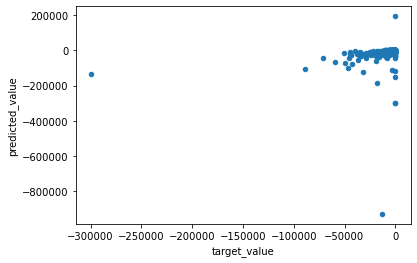

In [588]:
# The dispersion of target vs predicted values seems somewhat linear
optimization_results_df.plot(kind='scatter', x='target_value', y='predicted_value')

In [590]:
# But the R^2 score is not satisfying
r2_score(optimization_results_df['target_value'], optimization_results_df['predicted_value'])

-7.133571993191623

In [587]:
# The mean absolute error
mean_absolute_error(optimization_results_df['target_value'], optimization_results_df['predicted_value'])

6527.344529826008

In [608]:
# Can I add features to correct the prediction, for example the balance ?
linear_training_set = pd.concat([
    optimization_results_df['predicted_value'],
    pd.DataFrame.from_dict({
        account_id: pd.concat([timeseries['train'], timeseries['validation']]).resample('d').sum().sum().amount 
for account_id, timeseries in timeseries_training_dataset.items()}, orient='index', 
columns=['estimated_balance']),
], axis=1).dropna()

In [614]:
cv_scores = cross_val_score(
    linear_model.LinearRegression(), 
    linear_training_set, 
    optimization_results_df['target_value'].values.reshape(-1, 1))
f"Estimated an R^2 of {cv_scores.mean():.3f} with a standard deviation of {cv_scores.std():.3f}"
# This is not satisfactory

'Estimated an R^2 of 0.259 with a standard deviation of 0.263'

In [ ]:
# I had time to test up over here, I chose then to use the model with the best R^2 score and least MAE, 
# the Random Forests Regressor with vanilla hyperparameters